In [1]:
!nvidia-smi

Sat Sep 30 00:17:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8               1W / 140W |   3099MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


torch.cuda.amp.autocast(enabled=True)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []

test_incorrect_pred={
    'images':[], 'ground_truths':[],'predicted_vals':[]
}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_curves():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")
  plt.show()

In [4]:
def get_misclassified_images(model,test_loader,device,n):
    if n%5!=0:
        return("give multiple of 5")
    model.eval()
    
    images               = []
    predictions          = []
    labels               = []
    with torch.no_grad():
        for inputs,targets in test_loader:
            inputs  = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _,pred = torch.max(outputs,1)

            for i in range(len(pred)):
                if pred[i]!=targets[i]:
                    images.append(inputs[i])
                    predictions.append(pred[i])
                    labels.append(targets[i])
    # return images,predictions,labels
    assert len(images) == len(predictions) == len(labels)

    images=images[:n]
    predictions=predictions[:n]
    labels=labels[:n]
    
    classes = test_loader.dataset.classes
    
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        sub = fig.add_subplot(len(images) // 5, 5, i + 1)
        image = images[i]
        image = image.T
        npimg = image.cpu().numpy().squeeze()
        plt.imshow(npimg, cmap="gray")
        predicted = classes[predictions[i]]
        correct = classes[labels[i]]
        sub.set_title(
            "Correct class: {}\nPredicted class: {}".format(correct, predicted)
        )
    plt.tight_layout()

In [5]:
def show_images(loader):
    inputs,classes = next(iter(loader))
    inputs=inputs[:10]
    classes=inputs[:10]
    out = torchvision.utils.make_grid(inputs)
    plt.imshow(out,title=[i for i in classes])

In [6]:
class ConvLayer(nn.Module):
    def __init__(self,inc:int,outc:int,k:int,p:int,norm:str,dp_rate:int,grp:int=0):
        super(ConvLayer,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=3,padding=p,bias=False),
            self.get_norm(norm=norm,grp=grp,num_f=outc),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dp_rate)
        )

    def get_norm(self,norm:str,num_f:int,grp:int=0):
        if norm=='bn':
            return nn.BatchNorm2d(num_features=num_f)
        elif norm=='ln':
            return nn.GroupNorm(num_groups=1,num_channels=num_f)
        elif norm=='gn':
            return nn.GroupNorm(num_groups=grp,num_channels=num_f)
        else:
            raise ValueError("choose bn/ln/gn")

    def forward(self,x):
        x = self.layer(x)
        return x


class TransBlock(nn.Module):
    def __init__(self,inc:int,outc:int):
        super(TransBlock,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=1,bias=False),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
    def forward(self,x):
        x = self.layer(x)
        return x

class Model(nn.Module):
    def __init__(self,norm_method:str,grp:int):
        super(Model,self).__init__()
        self.dropout_rate = 0.1
        if not norm_method in('bn','ln','gn'):
            raise ValueError('choose bn/ln/gn')
        else:
            self.norm = norm_method
            if self.norm =='gn':
                self.grp=grp
            else:
                self.grp=0

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=16,k=3,p=1,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)
        )
        self.trans1 = TransBlock(inc=32,outc=16)
        
        self.conv2 = nn.Sequential(
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)
        )
        self.trans2 = TransBlock(inc=32,outc=16)
        
        self.conv3 = nn.Sequential(
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=32,outc=64,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)            
        )
        self.trans3 = TransBlock(inc=64,outc=16)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.out = nn.Conv2d(16,10,1,bias=False)
    
    def forward(self,x):
        x = self.trans1(self.conv1(x))
        x = self.trans2(self.conv2(x))
        x = self.trans3(self.conv3(x))
        x = self.gap(x)
        x = self.out(x)
        logit = F.log_softmax(x.view(-1,10), dim=1)
        return logit

In [7]:
model8 = Model(norm_method='gn',grp=8).to(device)
summary(model8,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvLayer-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
         GroupNorm-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
         Dropout2d-9           [-1, 32, 32, 32]               0
        ConvLayer-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             512
        MaxPool2d-12           [-1, 16, 16, 16]               0
       TransBlock-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

In [8]:
train_transforms =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-10,10)),
        # # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        # transforms.RandomCrop(32, padding=4),
        # transforms.autoaugment.AutoAugmentPolicy('cifar10')
    ])

test_transforms  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        )
    ])

train_data = datasets.CIFAR10('../data', train=True, download=False, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=False, transform=test_transforms)


if device.type=='cuda':
    kwargs = {'batch_size': 76, 'shuffle': True, 'num_workers': 4}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [9]:

optimizer = optim.SGD(model8.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# New Line
criterion =  F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model8, device, train_loader, optimizer)
  tl = test(model8, device, test_loader)
  scheduler.step(tl)

Epoch 1


Train: Loss=1.9748 Batch_id=657 Accuracy=21.41: 100%|████████████████████████████████| 658/658 [00:32<00:00, 20.43it/s]


Test set: Average loss: 1.9314, Accuracy: 2857/10000 (28.57%)

Epoch 2


Train: Loss=1.8826 Batch_id=657 Accuracy=29.06: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.15it/s]


Test set: Average loss: 1.8896, Accuracy: 3188/10000 (31.88%)

Epoch 3


Train: Loss=1.7196 Batch_id=657 Accuracy=31.76: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.29it/s]


Test set: Average loss: 1.7670, Accuracy: 3419/10000 (34.19%)

Epoch 4


Train: Loss=1.7452 Batch_id=657 Accuracy=34.60: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.19it/s]


Test set: Average loss: 1.7565, Accuracy: 3512/10000 (35.12%)

Epoch 5


Train: Loss=1.6431 Batch_id=657 Accuracy=36.54: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.55it/s]


Test set: Average loss: 1.6552, Accuracy: 3930/10000 (39.30%)

Epoch 6


Train: Loss=1.7956 Batch_id=657 Accuracy=37.89: 100%|████████████████████████████████| 658/658 [00:28<00:00, 22.83it/s]


Test set: Average loss: 1.6027, Accuracy: 4067/10000 (40.67%)

Epoch 7


Train: Loss=1.6279 Batch_id=657 Accuracy=39.03: 100%|████████████████████████████████| 658/658 [00:28<00:00, 22.72it/s]


Test set: Average loss: 1.6001, Accuracy: 4097/10000 (40.97%)

Epoch 8


Train: Loss=1.6325 Batch_id=657 Accuracy=40.03: 100%|████████████████████████████████| 658/658 [00:28<00:00, 23.07it/s]


Test set: Average loss: 1.5699, Accuracy: 4156/10000 (41.56%)

Epoch 9


Train: Loss=1.8395 Batch_id=657 Accuracy=41.44: 100%|████████████████████████████████| 658/658 [00:29<00:00, 21.95it/s]


Test set: Average loss: 1.5865, Accuracy: 4224/10000 (42.24%)

Epoch 10


Train: Loss=1.4163 Batch_id=657 Accuracy=42.22: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.03it/s]


Test set: Average loss: 1.5199, Accuracy: 4432/10000 (44.32%)

Epoch 11


Train: Loss=1.5222 Batch_id=657 Accuracy=42.82: 100%|████████████████████████████████| 658/658 [00:28<00:00, 22.77it/s]


Test set: Average loss: 1.4436, Accuracy: 4648/10000 (46.48%)

Epoch 12


Train: Loss=1.4563 Batch_id=657 Accuracy=43.67: 100%|████████████████████████████████| 658/658 [00:28<00:00, 22.78it/s]


Test set: Average loss: 1.4507, Accuracy: 4701/10000 (47.01%)

Epoch 13


Train: Loss=1.5724 Batch_id=657 Accuracy=44.30: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.58it/s]


Test set: Average loss: 1.4432, Accuracy: 4776/10000 (47.76%)

Epoch 14


Train: Loss=1.3720 Batch_id=657 Accuracy=44.97: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.53it/s]


Test set: Average loss: 1.4462, Accuracy: 4704/10000 (47.04%)

Epoch 15


Train: Loss=1.4768 Batch_id=657 Accuracy=45.69: 100%|████████████████████████████████| 658/658 [00:29<00:00, 22.67it/s]


Test set: Average loss: 1.3774, Accuracy: 5030/10000 (50.30%)

Epoch 16


Train: Loss=1.3991 Batch_id=657 Accuracy=45.91: 100%|████████████████████████████████| 658/658 [00:29<00:00, 21.95it/s]


Test set: Average loss: 1.4416, Accuracy: 4770/10000 (47.70%)

Epoch 17


Train: Loss=1.4126 Batch_id=657 Accuracy=46.47: 100%|████████████████████████████████| 658/658 [00:31<00:00, 21.01it/s]


Test set: Average loss: 1.3456, Accuracy: 5044/10000 (50.44%)

Epoch 18


Train: Loss=1.4778 Batch_id=657 Accuracy=46.99: 100%|████████████████████████████████| 658/658 [00:30<00:00, 21.63it/s]


Test set: Average loss: 1.3530, Accuracy: 5143/10000 (51.43%)

Epoch 19


Train: Loss=1.4597 Batch_id=657 Accuracy=48.03: 100%|████████████████████████████████| 658/658 [00:30<00:00, 21.38it/s]


Test set: Average loss: 1.3841, Accuracy: 5014/10000 (50.14%)

Epoch 20


Train: Loss=1.3177 Batch_id=657 Accuracy=48.00: 100%|████████████████████████████████| 658/658 [00:29<00:00, 21.99it/s]


Test set: Average loss: 1.3251, Accuracy: 5188/10000 (51.88%)



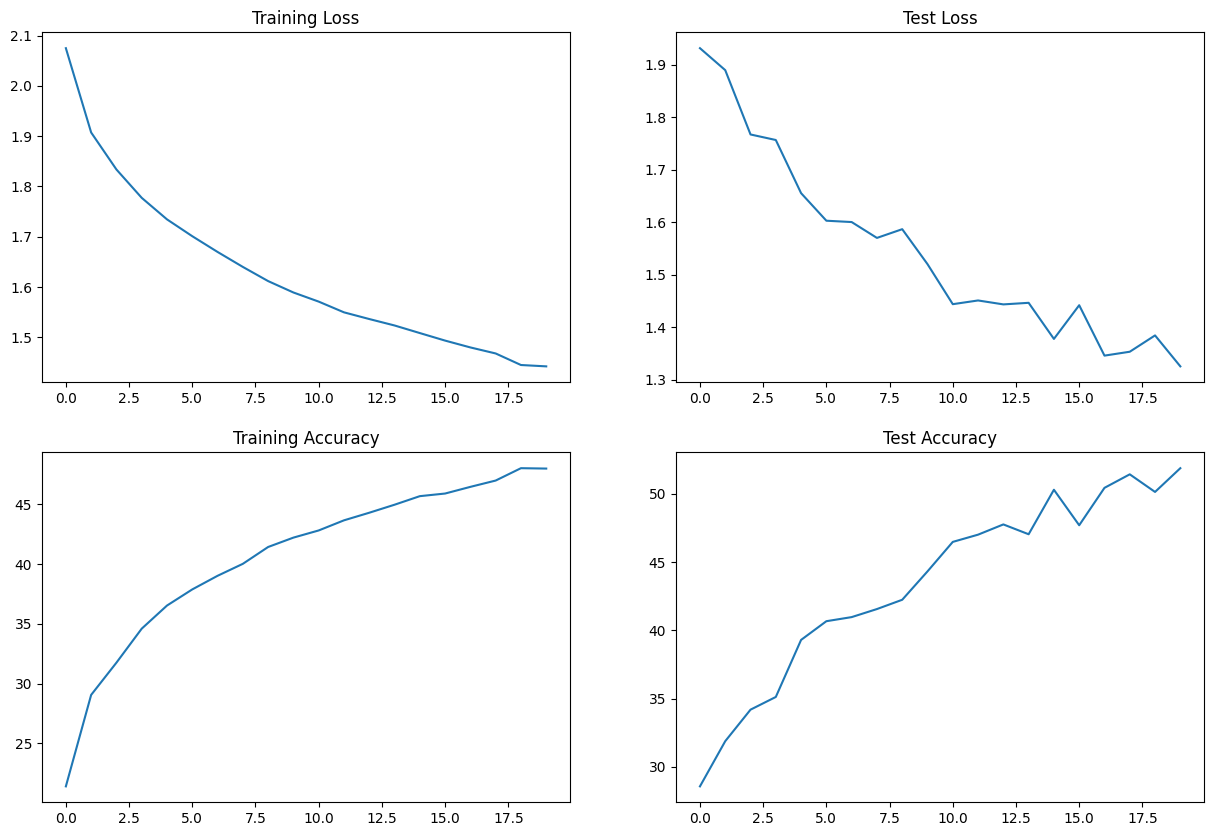

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()